In [2]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os
from PIL import Image

# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Text(0.5, 1.0, 'Pneumonia')

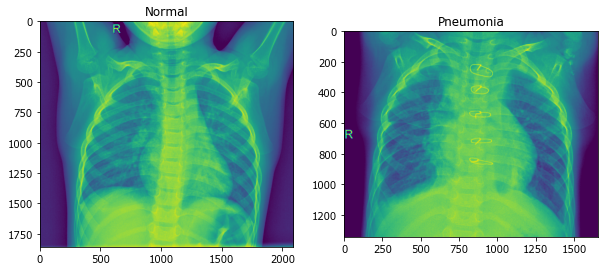

In [3]:
# Load the images & plot a couple of them
norm_load = Image.open('chest_xray/train/NORMAL/IM-0115-0001.jpeg')
sick_load = Image.open('chest_xray/train/PNEUMONIA/person3_bacteria_12.jpeg')

#Let's plt these images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sick_load)
a2.set_title('Pneumonia')


In [10]:
# Initialising the CNN
cnn = Sequential()

# Step 1 - Convolution
cnn.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
cnn.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
cnn.add(Flatten())

# Step 4 - Full connection
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
#Image augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory('chest_xray/val/',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')


test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
#fitting CNN
cnn_model = cnn.fit_generator(training_set,
                         steps_per_epoch = 200, #number of images in training set (for time reasons we use 200/5232)
                         epochs = 1,
                         validation_steps = 16) #number of images in validation set

Epoch 1/1
200/200 [==============================] - 127s 636ms/step - loss: 0.1905 - acc: 0.9238


In [28]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total para

In [29]:
test_accu = cnn.evaluate_generator(test_set,steps=624)

In [31]:
print('The testing accuracy is :',round(test_accu[1]*100,2), '%')

The testing accuracy is : 86.54 %
